In [1]:
import os
os.chdir('../')
import jhutil; jhutil.jhprint(1111, )

1111 


In [2]:
import sys
sys.path.append("Marigold")

import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from model import init_marigold, run_marigold

In [3]:
# 1. load model
marigold = init_marigold()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:

rgb_path = "/data2/wlsgur4011/DDGS/dataset/nerf_llff_data/horns/images_4/DJI_20200223_163016_842.png"
rgb_path = "/data2/wlsgur4011/DDGS/dataset/nerf_llff_data/horns/images_8/DJI_20200223_163016_842.png"
input_image = Image.open(rgb_path)

from torchvision import transforms
input_image_tensor = transforms.ToTensor()(input_image)
import jhutil; jhutil.jhprint(3333, input_image_tensor)
input_image = transforms.ToPILImage()(input_image_tensor)

3333  "tensor[3, 378, 504] n=571536 (2.2Mb) x∈[0., 1.000] μ=0.424 σ=0.235"


In [5]:
# 2. load data

import torch
from torchvision import transforms

data_path = "/data2/wlsgur4011/SparseDC/tmp/test_data.pt"
data = torch.load(data_path)

import jhutil; jhutil.jhprint(1111, data)
my_image_tensor = data['rgb'][0].cpu()
import jhutil; jhutil.jhprint(2222, my_image_tensor)
my_image = transforms.ToPILImage()(my_image_tensor)

1111  {
    "rgb": "tensor[1, 3, 228, 304] n=207936 (0.8Mb) x∈[0., 0.996] μ=0.481 σ=0.234 cuda:0",
    "dep": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[0., 3.566] μ=0.004 σ=0.118 cuda:0",
    "gt": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[1.811, 3.593] μ=2.924 σ=0.405 cuda:0"
}
2222  "tensor[3, 228, 304] n=207936 (0.8Mb) x∈[0., 0.996] μ=0.481 σ=0.234"


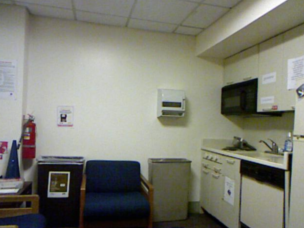

In [6]:
my_image

In [24]:
# 3. run model
depth = run_marigold(marigold, my_image)

1111  "tensor[1, 228, 304] n=69312 (0.3Mb) x∈[0.006, 1.000] μ=0.619 σ=0.218 cuda:0"


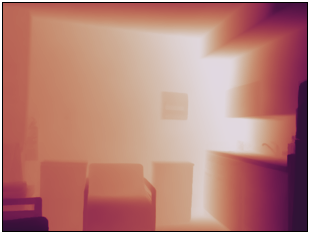

In [25]:
# 4. show depth
depth = torch.tensor(depth)[None, :].cuda()
import jhutil; jhutil.jhprint(1111, depth)
depth.chans

1111  "tensor[1, 228, 304] n=69312 (0.3Mb) x∈[1.811, 3.593] μ=2.924 σ=0.405 cuda:0"


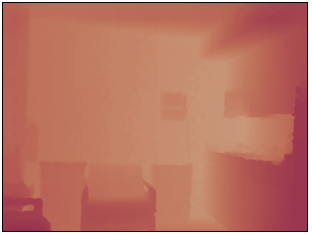

In [26]:
# 5. gt depth
gt_depth = data['gt'][0]
import jhutil; jhutil.jhprint(1111, gt_depth)
(gt_depth / 5).chans

1111  "tensor[1, 228, 304] bool n=69312 (68Kb) x∈[False, True] μ=0.001 σ=0.038 cuda:0"


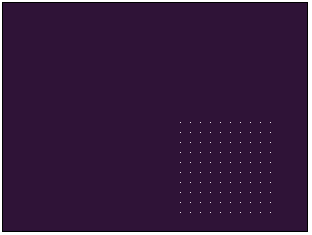

In [27]:
mask = data['dep'][0] != 0
import jhutil; jhutil.jhprint(1111, mask)
mask.chans

In [28]:
# copy from MiDaS
def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    valid = det.nonzero()

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1


In [29]:
scale, shift = compute_scale_and_shift(depth, gt_depth, mask)
depth = scale.view(-1, 1, 1) * depth + shift.view(-1, 1, 1)


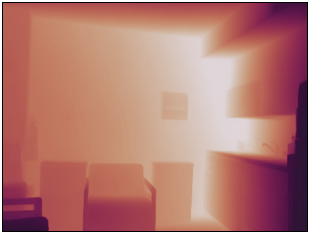

In [44]:
((depth - depth.min()) / 2). chans

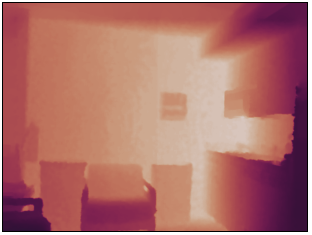

In [45]:
((gt_depth - gt_depth.min()) / 2).chans